## 4.5 Weight Decay
### 4.5.1 Norms and Weight Decay
$L(\mathbf{w},b)+\frac{\lambda}2||\mathbf{w}||^2$

$\mathbf{w}\leftarrow(1-\eta\lambda)\mathbf{w}-\frac{\eta}{|\mathcal{B}}\sum_{i\in\mathcal{B}}\mathbf{x}^{(i)}(\mathbf{w}^T\mathbf{x}^{(i)}+b-y^{(i)})$

### 4.5.2 High-Dimensional Linear Regression

In [1]:
%matplotlib inline
from d2l import mxnet as d2l
from mxnet import autograd, gluon, init, np, npx
from mxnet.gluon import nn
npx.set_np()

data:$y=0.05+\sum_{i=1}^d 0.01x_i+\epsilon, \epsilon\sim\mathcal{N}(0,0.01^2)$

In [2]:
n_train, n_test, num_inputs, batch_size=20,100,200,5
true_w, true_b=np.ones((num_inputs,1))*0.01,0.05
train_data=d2l.synthetic_data(true_w,true_b,n_train)
train_iter=d2l.load_array(train_data,batch_size)
test_data=d2l.synthetic_data(true_w,true_b,n_test)
test_iter=d2l.load_array(test_data,batch_size)

### 4.5.3 Implementation from Scratch

In [8]:
# Initializing Model Parameters
def init_params():
    w=np.random.normal(scale=1,size=(num_inputs,1))
    b=np.zeros(1)
    w.attach_grad()
    b.attach_grad()
    return [w,b]
def l2_penalty(w):
    return (w**2).sum()/2

In [9]:
# Defining the Training Loop
def train(lambda_para):
    w,b=init_params()
    net,loss=lambda X:d2l.linreg(X,w,b),d2l.squared_loss
    num_epochs, lr=100,0.003
    animator=d2l.Animator(xlabel='epochs',ylabel='loss',yscale='log',
        xlim=[5,num_epochs],legend=['train','test'])
    for epoch in range(num_epochs):
        for X,y in train_iter:
            with autograd.record():
                l=loss(net(X),y)+lambda_para*l2_penalty(w)
            l.backward()
            d2l.sgd([w,b],lr,batch_size)
        if (epoch+1)%5==0:
            animator.add(epoch+1,
                (d2l.evaluate_loss(net,train_iter,loss),d2l.evaluate_loss(net,test_iter,loss)))
    print("L2 norm of w:", np.linalg.norm(w))

L2 norm of w: 14.178585


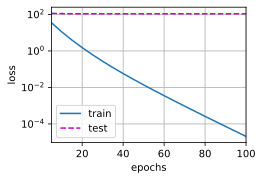

In [10]:
# Training without Regularization
train(lambda_para=0)

L2 norm of w: 0.40446925


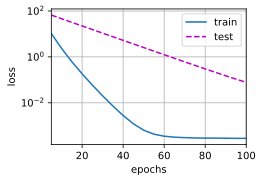

In [11]:
# Using Weight Decay
train(lambda_para=3)

### 4.5.4 Concise Implementation

In [12]:
def train_concise(wd):
    # wd: Weight Decay Hyper-Parameter
    net=nn.Sequential()
    net.add(nn.Dense(1))
    net.initialize(init.Normal(sigma=1))
    loss=gluon.loss.L2Loss()
    num_epochs, lr=100,0.03
    trainer=gluon.Trainer(net.collect_params(),'sgd',{'learning_rate':lr,'wd':wd})
    # 设置「偏置」的参数不衰减
    net.collect_params('.*bias').setattr('wd_mult',0)
    animator=d2l.Animator(xlabel='epochs',ylabel='loss',yscale='log',xlim=[5,num_epochs],
        legend=['train','test'])
    for epoch in range(num_epochs):
        for X,y in train_iter:
            with autograd.record():
                l=loss(net(X),y)
            l.backward()
            trainer.step(batch_size)
        if (epoch+1)%5==0:
            animator.add(epoch+1,
                (d2l.evaluate_loss(net,train_iter,loss),d2l.evaluate_loss(net,test_iter,loss)))
    print("L2 norm of w:", np.linalg.norm(net[0].weight.data()))

L2 norm of w: 12.582346


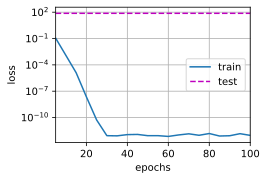

In [13]:
# Training without Regularization
train_concise(0)

L2 norm of w: 0.026280338


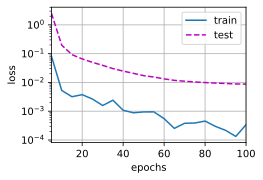

In [14]:
# Using Weight Decay
train_concise(3)